# Have functions in scripts
# Final code presentation in notebook
# Have testing implementation set up, even if not great tests
# Have Travis set up
# Try different data sets: dense data, spread data, more or less points, smaller or larger uncertainties

In [1]:
import astropy.units as u
import astropy.constants as cons
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Defining the true parameters of the system
mstar=1.*cons.M_sun #Stellar mass [kg]
mplanet=5*cons.M_jup #Planet mass [kg]
a=2*cons.au #Semimajor axis [m]
distance_to_star=5*u.pc #Earth-system distance [m]
mu=cons.G*(mstar+mplanet)
T=np.sqrt(4*np.pi**2.*a**3./mu) #Period [s]
e=.66 #Eccentricity
n=2.*np.pi/T #Mean motion
times=np.linspace(0, T, 25) #Times to sample from
tau=0 #Time/Epoch of Pericentre/Periastron Passage (should be in BJD?)
rs=np.zeros(len(times)) #Star-planet distance
cos_true_anomalies=np.zeros(len(times)) 
true_anomalies=np.zeros(len(times)) #True anomaly (angle around orbit)
mean_anomalies=n*(times-tau) #Mean anomaly

In [3]:
#Iterative scheme to solve Kepler's Eq. as a function of time
#described on Solar System Dynamics pg 36(Murray, Dermott)
for i in range(len(times)):
    k=0.85 #Suggested by Murray&Dermott
    mean_anomaly=mean_anomalies[i]
    eccentric_anomaly_0=mean_anomaly+np.sign(np.sin(mean_anomaly*u.rad))*k*e #First guess
    eccentric_anomaly_i=eccentric_anomaly_0
    for i in range(5): #For low eccentricities, takes very few (~1) iteration to converge
        fppp=e*np.cos(eccentric_anomaly_i*u.rad)
        fpp=e*np.sin(eccentric_anomaly_i*u.rad)
        fp=1.-e*np.cos(eccentric_anomaly_i*u.rad)
        f=eccentric_anomaly_i-e*np.sin(eccentric_anomaly_i*u.rad)-mean_anomaly
        d1=-f/fp
        d2=-f/(fp+.5*d1*fpp)
        d3=-f/(fp+.5*d2*fpp+(1/6.)*d2**2.*fppp)
        eccentric_anomaly_next=eccentric_anomaly_i+d3
        eccentric_anomaly_i=eccentric_anomaly_next
    cos_true_anomaly=(np.cos(eccentric_anomaly_next*u.rad)-e)/(1.-e*np.cos(eccentric_anomaly_next*u.rad))
    cos_true_anomalies[i]=cos_true_anomaly
    r=a*(1.-e**2.)/(1.+e*cos_true_anomaly)
    rs[i]=r
    true_anomaly=2.*np.arctan(np.sqrt((1+e)/(1-e))*np.tan(eccentric_anomaly_next*u.rad/2.))
    true_anomalies[i]=true_anomaly

In [4]:
#Attach unit to array instead of elements
rs=[r.value for r in rs]*u.m 
true_anomalies=[true_anomaly.value for true_anomaly in true_anomalies]*u.rad

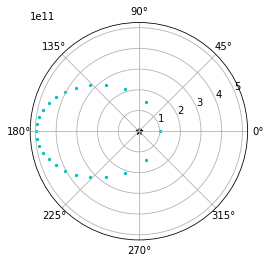

In [5]:
#Plotting in polar coords
ax=plt.subplot(111, polar=True)
ax.scatter(0,0, color='k', marker='*', s=50)
for i, t in enumerate(times):
    ax.scatter(true_anomalies[i], rs[i], color='c', s=5)
plt.show()

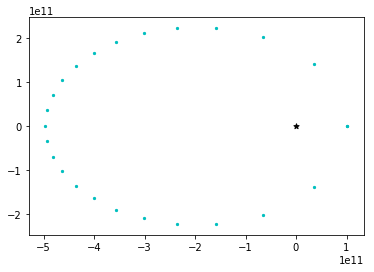

In [6]:
#Plotting in cartesian coords
f,ax=plt.subplots(1,1)
ax.scatter(0,0, marker='*', color='k', s=30)
for i, t in enumerate(times):
    ax.scatter(rs[i]*np.cos(true_anomalies[i]), rs[i]*np.sin(true_anomalies[i]), color='c', s=5)
plt.show()

In [56]:
t_yrs=[t.to('year') for t in times]

In [8]:
#x_pos=[r.value for r in rs]*np.cos([f.value for f in fs])*u.m
#y_pos=[r.value for r in rs]*np.sin([f.value for f in fs])*u.m
#sigma_x_mas=10*u.mas
#sigma_y_mas=10*u.mas

def mas_unc_to_m_unc(dist, mas_unc):
    radians_unc=mas_unc.to('rad')
    m_unc=np.tan(radians_unc)*dist
    return m_unc.to('m')

#sigma_x_m=mas_unc_to_m_unc(distance_to_star, sigma_x_mas)
#sigma_y_m=mas_unc_to_m_unc(distance_to_star, sigma_y_mas)

#If sigma_x_m==sigma_y_m, then sigma_r_m=sigma_r_x, and sigma_theta too, is this right?

#Paper I'm imitating (Wang et al. 2016: 1607.05272) has ~1mas uncertainties on position, ~.2degree uncertainties on position angle
#I use larger uncertainties, will make an argument of a future function
sigma_true_anomaly=(1*u.deg).to('rad')
sigma_r=mas_unc_to_m_unc(distance_to_star, 10*u.mas) 


#How do I incorporate mass as an observable with uncertainties
sigma_mass=.05*mstar
sigma_dist=.01*distance_to_star

In [57]:
#Add gaussian noise to the data
noisy_rs=rs+sigma_r*np.random.normal(loc=0, size=len(rs))
noisy_true_anomalies=true_anomalies+sigma_true_anomaly*np.random.normal(loc=0, size=len(true_anomalies))
noisy_mass=mstar+sigma_mass*np.random.normal(loc=0, size=1)
noisy_distance=distance_to_star+sigma_dist*np.random.normal(loc=0, size=1)

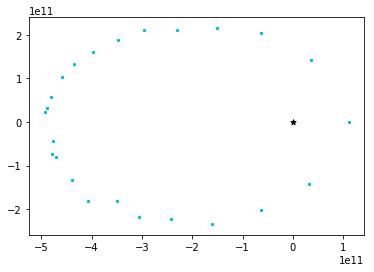

In [59]:
#Cartesian plot of data with gaussian noise
f,ax=plt.subplots(1,1)
ax.scatter(0,0, marker='*', color='k', s=30)
for i, t in enumerate(times[:-1]):
    ax.scatter(noisy_rs[i]*np.cos(noisy_true_anomalies[i]), noisy_rs[i]*np.sin(noisy_true_anomalies[i]), color='c', s=5)
plt.show()

In [11]:
data=[noisy_true_anomalies[8:14], noisy_rs[8:14]]
info=[times[8:14], sigma_true_anomaly, sigma_r]
#Cartesian plot of data with gaussian noise
f,ax=plt.subplots(1,1)
ax.scatter(0,0, marker='*', color='k', s=30)
for i, t in enumerate(times[:-1]):
    ax.scatter(noisy_rs[i]*np.cos(noisy_true_anomalies[i]), noisy_rs[i]*np.sin(noisy_true_anomalies[i]), color='c', s=5)
plt.show()

# To debug: 
 test lnlike for true values
 plot lnlike for different noise realizations
    on average this should be centered at the truth
 test on the pos value which is minimization plus random noise

In [60]:
def lnlike(pars, data, info):
    mpm, e, a, time_periastron, arg_periastron = pars
    mpm=mpm*u.kg
    a=a*u.m
    T=np.sqrt(4.*np.pi**2.*a**3./(cons.G*mpm))
    times, sigma_theta, sigma_r = info
    thetas, rs=data
    mean_anomalies=(2.*np.pi)*(times-time_periastron*u.s)/T
    chis=np.zeros(len(times)*2)
    for i in range(len(times)):
        k=0.85
        mean_anomaly=mean_anomalies[i]
        eccentric_anomaly_0=mean_anomaly+np.sign(np.sin(mean_anomaly*u.rad))*k*e
        eccentric_anomaly_i=eccentric_anomaly_0
        for j in range(10):
            fppp=e*np.cos(eccentric_anomaly_i*u.rad)
            fpp=e*np.sin(eccentric_anomaly_i*u.rad)
            fp=1.-e*np.cos(eccentric_anomaly_i*u.rad)
            f=eccentric_anomaly_i-e*np.sin(eccentric_anomaly_i*u.rad)-mean_anomaly
            d1=-f/fp
            d2=-f/(fp+.5*d1*fpp)
            d3=-f/(fp+.5*d2*fpp+(1/6.)*d2**2.*fppp)
            eccentric_anomaly_next=eccentric_anomaly_i+d3
            eccentric_anomaly_i=eccentric_anomaly_next
        cos_true_anomaly=(np.cos(eccentric_anomaly_next*u.rad)-e)/(1.-e*np.cos(eccentric_anomaly_next*u.rad))
        cos_true_anomalies.append(cos_true_anomaly)
        true_r=a*(1.-e**2.)/(1.+e*cos_true_anomaly)
        #true_radii.append(r)
        true_anomaly=2.*np.arctan(np.sqrt((1+e)/(1-e))*np.tan(eccentric_anomaly_next*u.rad/2.))
        #true_anoms.append(true_anomaly)
        chis[2*i]=(thetas[i]-true_anomaly)/sigma_theta
        chis[2*i+1]=(rs[i]-true_r)/sigma_r
    chis=np.array(chis)
    return -0.5*(np.sum(chis*chis))

# BELOW CELL IS INTENSIVE DO NOT RERUN

In [13]:
import scipy.optimize as op
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [(mstar+mplanet).value, e, a.value, 0, 0], args=(data, info))
mpmm, em, am, taum, argm = result["x"]

In [14]:
def lnprior(pars):
    mpm, e, a, time_periastron, arg_periastron = pars
    if 0 < mpm < 6*cons.M_sun.value and 0.0001 < e < 0.99 and 1*cons.au.value < a < 20*cons.au.value and -1 < time_periastron < 1 and -2*np.pi < arg_periastron < 2*np.pi:
        return 0.0
    return -np.inf

In [15]:
def lnprob(pars, data, info):
    lp = lnprior(pars)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(pars, data, info)

In [16]:
ndim, nwalkers = 5, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [17]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(data, info))

# BELOW CELL INTENSIVE

In [18]:
sampler.run_mcmc(pos, 10)


(array([[  1.99859350e+30,   6.29595553e-01,   2.99195741e+11,
           2.05037304e-04,   7.42855300e-06],
        [  1.99859350e+30,   6.28141159e-01,   2.99195741e+11,
           6.30435877e-06,  -1.91797584e-03],
        [  1.99859350e+30,   6.29663007e-01,   2.99195741e+11,
           1.48087591e-04,  -2.02782544e-04],
        [  1.99859350e+30,   6.29921553e-01,   2.99195741e+11,
           9.98662750e-05,   4.19571544e-04],
        [  1.99859350e+30,   6.30811784e-01,   2.99195741e+11,
           3.18800040e-04,   6.83551276e-04],
        [  1.99859350e+30,   6.27135348e-01,   2.99195741e+11,
           5.86696998e-04,  -7.10611117e-05],
        [  1.99859350e+30,   6.30191238e-01,   2.99195741e+11,
          -2.26830781e-03,  -1.37661083e-04],
        [  1.99859350e+30,   6.29851348e-01,   2.99195741e+11,
           3.44876502e-05,   2.21925087e-04],
        [  1.99859350e+30,   6.24825179e-01,   2.99195741e+11,
          -2.87238457e-03,  -1.83472849e-03],
        [  1.998593

In [22]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
mpmm, em, am, taum, argm

(1.9985935e+30,
 0.62979071236105277,
 299195741400.0,
 3.0179485652119334e-06,
 0.0)

In [23]:
import corner
fig = corner.corner(samples[:,1:], labels=["$e$", "$a$", "$\tau$", "$\varpi$"])
plt.savefig('mcmctest.pdf')

AssertionError: I don't believe that you want more dimensions than samples!

In [ ]:
for i in range(5):
    print(samples[:,i].min(), samples[:,i].max())

In [28]:
samples = sampler.chain[:, :, :].reshape((-1, ndim))


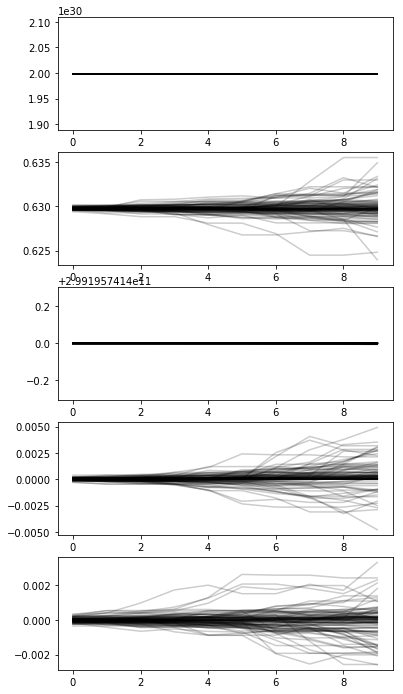

In [62]:
f, axs=plt.subplots(5,1, figsize=(6,12))
for i, ax in enumerate(f.axes):
    for j in range(sampler.chain.shape[0]):
        ax.plot(sampler.chain[j,:,i], color='k', alpha=0.2)
plt.show()

In [52]:
sampler.chain[0].shape

(10, 5)